In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import mat73
from scipy.linalg import dft
from scipy import linalg
from scipy.signal import butter, iirnotch, lfilter, freqz, filtfilt
from scipy.fft import fft, fftfreq
import warnings
%matplotlib inline

In [2]:
with open('ssvep/classInfo_4_5.m') as f:
    targets_str= f.read().split('\n')

targets=[]
for label in targets_str[:-1]:
    targets.append(list(map(int,label.split(' '))))

In [3]:
subject= 1
sub1_train1_data = 'ssvep/subject_1_fvep_led_training_1.mat'
sub1_train2_data = 'ssvep/subject_1_fvep_led_training_2.mat'
sub2_train1_data = 'ssvep/subject_2_fvep_led_training_1.mat'
sub2_train2_data = 'ssvep/subject_2_fvep_led_training_2.mat'

data_dict_sub1_train1 = mat73.loadmat(sub1_train1_data)
data_dict_sub1_train2 = mat73.loadmat(sub1_train2_data)
data_dict_sub2_train1 = mat73.loadmat(sub2_train1_data)
data_dict_sub2_train2 = mat73.loadmat(sub2_train2_data)

print(data_dict_sub1_train1.keys(), data_dict_sub1_train2.keys(), data_dict_sub2_train1.keys(), data_dict_sub2_train2.keys())

data_sub1_train1 = data_dict_sub1_train1['y']
data_sub1_train2 = data_dict_sub1_train2['y']
data_sub2_train1 = data_dict_sub2_train1['y']
data_sub2_train2 = data_dict_sub2_train2['y']

print(data_sub1_train1.shape, data_sub1_train2.shape, data_sub2_train1.shape, data_sub2_train2.shape)

dict_keys(['y']) dict_keys(['y']) dict_keys(['y']) dict_keys(['y'])
(11, 57728) (11, 58112) (11, 58757) (11, 57697)


In [4]:
print((data_sub1_train1[10]==0).sum(), (data_sub1_train1[10]==1).sum(), (data_sub1_train1[10]==2).sum(), (data_sub1_train1[10]==3).sum(), (data_sub1_train1[10]==4).sum())
print((data_sub1_train2[10]==0).sum(), (data_sub1_train2[10]==1).sum(), (data_sub1_train2[10]==2).sum(), (data_sub1_train2[10]==3).sum(), (data_sub1_train2[10]==4).sum())
print((data_sub2_train1[10]==0).sum(), (data_sub2_train1[10]==1).sum(), (data_sub2_train1[10]==2).sum(), (data_sub2_train1[10]==3).sum(), (data_sub2_train1[10]==4).sum())
print((data_sub2_train2[10]==0).sum(), (data_sub2_train2[10]==1).sum(), (data_sub2_train2[10]==2).sum(), (data_sub2_train2[10]==3).sum(), (data_sub2_train2[10]==4).sum())

51072 0 0 6656 0
50832 156 0 6344 780
32289 5408 4212 1768 15080
29097 3328 2912 2548 19812


In [5]:
def get_trigger_intervals(data):
    intervals_start= []
    intervals_end= []

    for i in range(0,len(data[9])-1):
        if data[9,i]==0 and data[9,i+1]==1:
            intervals_start.append(i+1)
        if data[9,i]==1 and data[9,i+1]==0:
            intervals_end.append(i+1)
    assert len(intervals_start)== len(intervals_end)

    import numpy as np
    intervals = np.array([intervals_start, intervals_end]).T

    return intervals

def get_label_array(data):
    intervals = get_trigger_intervals(data) 
    labels = np.zeros((data.shape[1]))
    class_=1
    for interval in intervals:
        labels[interval[0]:interval[1]]= class_
        class_+=1
        if class_==5:class_=1
    return labels

def get_segment(data_channel, intervals):
    output = []
    if len(data_channel.shape)==1:
        for interval in intervals:
            output.append(data_channel[interval[0]: interval[1]])
    
    elif len(data_channel.shape)==2:
        for interval in intervals:
            output.append(data_channel[:,interval[0]: interval[1]])
    return np.array(output)

def create_dataset(sample_eeg, sample_labels, window_size=10):
    eegs=[]
    labels=[]
    for idx in range(len(sample_eeg)):
        eeg_chunk = sample_eeg[idx]
        label_chunk= sample_labels[idx]
        for i in range(0, eeg_chunk.shape[1]- window_size, window_size):
            eegs.append(eeg_chunk[:,i:i+window_size])
            labels.append(label_chunk[i])
            for k in range(len(label_chunk)-1):
                assert label_chunk[k]==label_chunk[k+1]
    return np.array(eegs), np.array(labels)



In [6]:
name1= "data_sub1_train1"
data1 = data_sub1_train1

name2= "data_sub1_train2"
data2 = data_sub1_train2

name3= "data_sub2_train1"
data3 = data_sub2_train1

name4= "data_sub2_train2"
data4 = data_sub2_train2

In [7]:
def filter_eeg(eeg_signal):
    b1, a1 = butter(N=6, Wn=[0.5, 30], btype='bandpass', fs=256)
    b2, a2 = iirnotch(w0= 50, Q=30, fs=256)
    
    filtered_eeg = filtfilt(b1, a1, eeg_signal)
    filtered_eeg2 = filtfilt(b2, a2, filtered_eeg)
    return filtered_eeg2

In [8]:
def prep_data(data):
    intervals = get_trigger_intervals(data)
    labels = get_label_array(data)

    samples_labels= get_segment(labels, intervals)
    samples_lda_preds= get_segment(data[10], intervals)
    samples_eeg= get_segment(data[1:9], intervals)

    eegs,labels = create_dataset(samples_eeg, samples_labels, window_size=768) # window_size -> timestamps
    eegs.shape, eegs[0].shape, labels.shape, labels[0]
    
    filtered_eegs= []
    for eeg in eegs:
        filtered_eegs.append(filter_eeg(eeg))
    filtered_eegs= np.array(filtered_eegs)
    
    return filtered_eegs,labels

In [9]:
filtered_eegs1,labels1 = prep_data(data1)
filtered_eegs2,labels2 = prep_data(data2)

filtered_eegs3 = np.append(filtered_eegs1,filtered_eegs2, axis=0)
labels3 = np.append(labels1, labels2, axis=0)

print(filtered_eegs1.shape,labels1.shape)
print(filtered_eegs2.shape,labels2.shape)
print(filtered_eegs3.shape,labels3.shape)

(40, 8, 768) (40,)
(40, 8, 768) (40,)
(80, 8, 768) (80,)


In [10]:
filtered_eegs21,labels21 = prep_data(data3)
filtered_eegs22,labels22 = prep_data(data4)

filtered_eegs23 = np.append(filtered_eegs21,filtered_eegs22, axis=0)
labels23 = np.append(labels21, labels22, axis=0)

print(filtered_eegs21.shape,labels21.shape)
print(filtered_eegs22.shape,labels22.shape)
print(filtered_eegs23.shape,labels23.shape)

(40, 8, 768) (40,)
(40, 8, 768) (40,)
(80, 8, 768) (80,)


In [11]:
# for tsfresh
from tsfresh import extract_relevant_features
from tsfresh import extract_features, select_features

In [12]:
def ready_for_tsf(eegs, labels):
    # generatig X dataframe
    dfx = pd.DataFrame(columns = ['eeg1','eeg2','eeg3','eeg4','eeg5','eeg6','eeg7','eeg8','id'])
    for i in range(eegs.shape[0]):
        if i == 0:
            temp = eegs[i].T
            ids = np.pad(np.array([i]),(0,eegs[i].shape[1]-1),'constant',constant_values = i)
            print(temp.shape, ids.shape)
            continue
    
        temp = np.append(temp, eegs[i].T, axis=0)
        ids = np.append(ids,np.pad(np.array([i]),(0,eegs[i].shape[1]-1),'constant',constant_values = i))
#     print(temp.shape, ids.shape)
    for j in range(8):
        dfx['eeg'+str(j+1)] = temp[:,j]
#     print(dfx)
    dfx['id'] = ids

    # generate a unique id for each movement based on gesture and iteration values
    dfy = pd.DataFrame()
    dfy['id']  = ids
    # dropping ALL duplicte values
    dfy = dfy.drop_duplicates()
    dfy['y'] 	= labels

    # save files
#     print(dfy)
#     save_file(df, configs(save_folder,'file_tsf_input_x'))
#     save_file(dfy, configs(save_folder,'file_tsf_input_y'))
    return dfx,dfy

In [13]:
def run_tsfresh(eegs,labels):

    dfx,dfy = ready_for_tsf(eegs, labels)
    y =  pd.Series(data=dfy["y"].values, index=dfy["id"].values)
    
    #   # Removing mean and scaling - if the following section is needed uncomment it
#     grouped = dfx.groupby(dfx.id)
#     ids = dfx['id']
#     ids = list(set(ids))
#     ids.sort()
#     for i in ids:
#         if i == ids[0]:
#             X = scaled_gesture(grouped,i)
#             continue

#         scaled_g = scaled_gesture(grouped,i)
#         X = X.append(scaled_g, ignore_index=True)


#     print(X.head())
#     print(y.head())

    fc_parameters = {
    "spkt_welch_density":  [{"coeff": 9}, {"coeff": 10}, {"coeff": 12}, {"coeff": 15}]
    }

    warnings.simplefilter("ignore")
#     features_filtered = extract_relevant_features(dfx, y, column_id='id',n_jobs=0)
    features_filtered = extract_features(dfx, default_fc_parameters=fc_parameters, column_id='id')
#     print(features_filtered.head())
    print('TSF finished')
    return features_filtered

In [14]:
X11 = run_tsfresh(filtered_eegs1,labels1)
ocolumns = X11.columns
y11 = labels1

X12 = run_tsfresh(filtered_eegs2,labels2)
ocolumns = X12.columns
y12 = labels2

X13 = run_tsfresh(filtered_eegs3,labels3)
ocolumns = X13.columns
y13 = labels3

X21 = run_tsfresh(filtered_eegs21,labels21)
ocolumns = X21.columns
y21 = labels21

X22 = run_tsfresh(filtered_eegs22,labels22)
ocolumns = X12.columns
y22 = labels22

X23 = run_tsfresh(filtered_eegs23,labels23)
ocolumns = X23.columns
y23 = labels23

(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 44.68it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 26.77it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 32.78it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 47.68it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s]

TSF finished


In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA                 # for dimensionality reduction using PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns            # visualization tool
import matplotlib.cm as cm       # for colour mapping to use for the pca plots

In [16]:
def run(X,y,ocolumns):
    scaler = preprocessing.MinMaxScaler()   # since the data set is not gaussian
    scaled_df = scaler.fit_transform(X)
    X = pd.DataFrame(scaled_df,columns = ocolumns)
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, stratify = y)
    
    param_grid = {'C': [0.01,0.1, 1, 10, 100,1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10,100]}
    clf_grid = GridSearchCV(SVC(kernel = 'linear'), param_grid)
    clf_grid.fit(X, y)
#     print("Best Parameters:\n", clf_grid.best_params_
    
    svclassifier = SVC(kernel = 'linear',C = clf_grid.best_params_['C'], gamma = clf_grid.best_params_['gamma'])
    
    svclassifier.fit(X_train,y_train)
    
    y_pred = svclassifier.predict(X_test)
    #result = [y_pred[i] == y_test[i] for i in range(len(y_test))]
    f,ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, linewidths=.1, fmt= '.0f',ax=ax).set_ylim(4,0)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    print(list(y_test),list(y_pred))
    print(classification_report(y_test,y_pred))

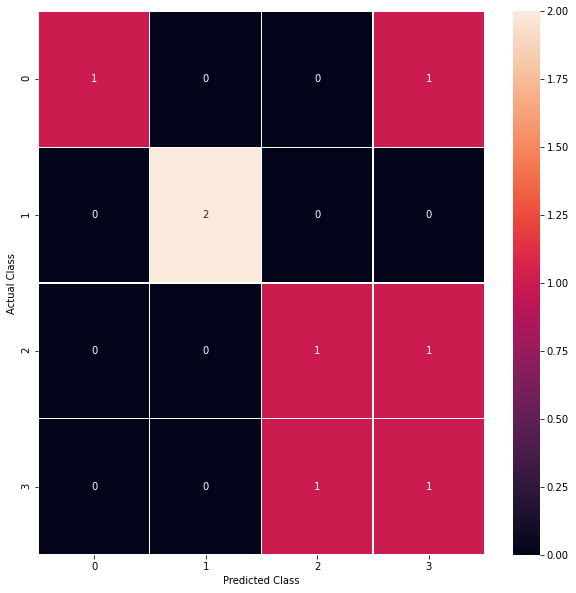

[2.0, 3.0, 2.0, 3.0, 4.0, 4.0, 1.0, 1.0] [2.0, 3.0, 2.0, 4.0, 3.0, 4.0, 4.0, 1.0]
              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         2
         2.0       1.00      1.00      1.00         2
         3.0       0.50      0.50      0.50         2
         4.0       0.33      0.50      0.40         2

    accuracy                           0.62         8
   macro avg       0.71      0.62      0.64         8
weighted avg       0.71      0.62      0.64         8



In [25]:
run(X11,y11,ocolumns)

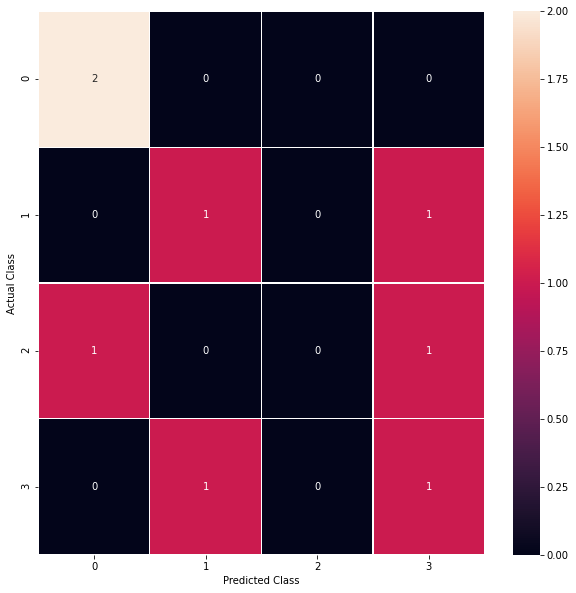

[1.0, 3.0, 4.0, 1.0, 3.0, 2.0, 2.0, 4.0] [1.0, 1.0, 2.0, 1.0, 4.0, 4.0, 2.0, 4.0]
              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80         2
         2.0       0.50      0.50      0.50         2
         3.0       0.00      0.00      0.00         2
         4.0       0.33      0.50      0.40         2

    accuracy                           0.50         8
   macro avg       0.37      0.50      0.43         8
weighted avg       0.37      0.50      0.43         8



In [17]:
run(X12,y12,ocolumns)

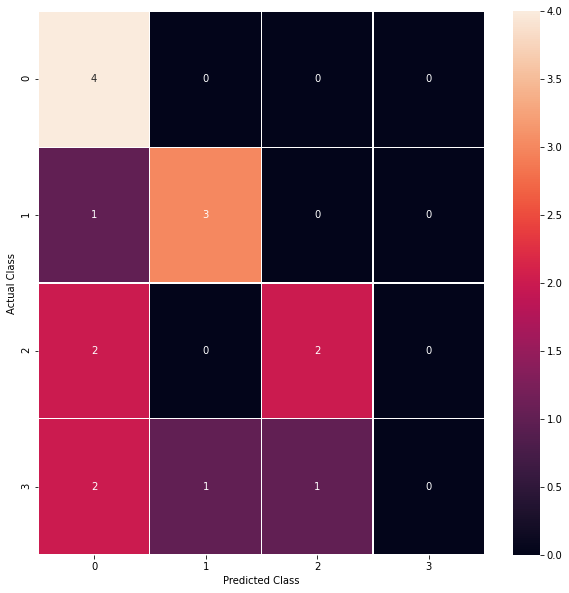

[2.0, 1.0, 3.0, 3.0, 2.0, 1.0, 1.0, 3.0, 4.0, 4.0, 4.0, 1.0, 2.0, 2.0, 4.0, 3.0] [2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 2.0, 1.0, 2.0, 3.0]
              precision    recall  f1-score   support

         1.0       0.44      1.00      0.62         4
         2.0       0.75      0.75      0.75         4
         3.0       0.67      0.50      0.57         4
         4.0       0.00      0.00      0.00         4

    accuracy                           0.56        16
   macro avg       0.47      0.56      0.48        16
weighted avg       0.47      0.56      0.48        16



In [17]:
run(X13,y13,ocolumns)

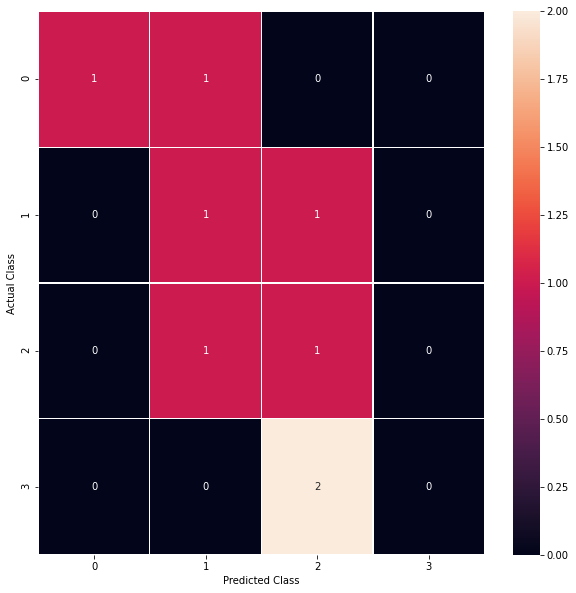

[1.0, 4.0, 3.0, 2.0, 4.0, 1.0, 3.0, 2.0] [1.0, 3.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0]
              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         2
         2.0       0.33      0.50      0.40         2
         3.0       0.25      0.50      0.33         2
         4.0       0.00      0.00      0.00         2

    accuracy                           0.38         8
   macro avg       0.40      0.38      0.35         8
weighted avg       0.40      0.38      0.35         8



In [19]:
run(X21,y21,ocolumns)

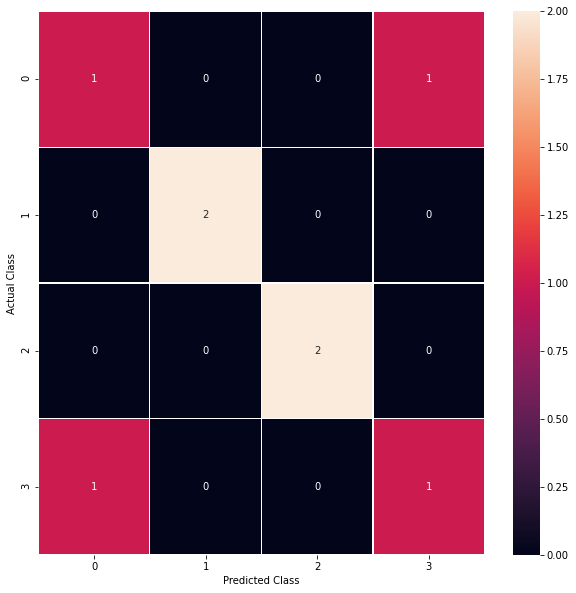

[2.0, 1.0, 3.0, 2.0, 4.0, 4.0, 1.0, 3.0] [2.0, 4.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0]
              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50         2
         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         2
         4.0       0.50      0.50      0.50         2

    accuracy                           0.75         8
   macro avg       0.75      0.75      0.75         8
weighted avg       0.75      0.75      0.75         8



In [17]:
run(X22,y22,ocolumns)

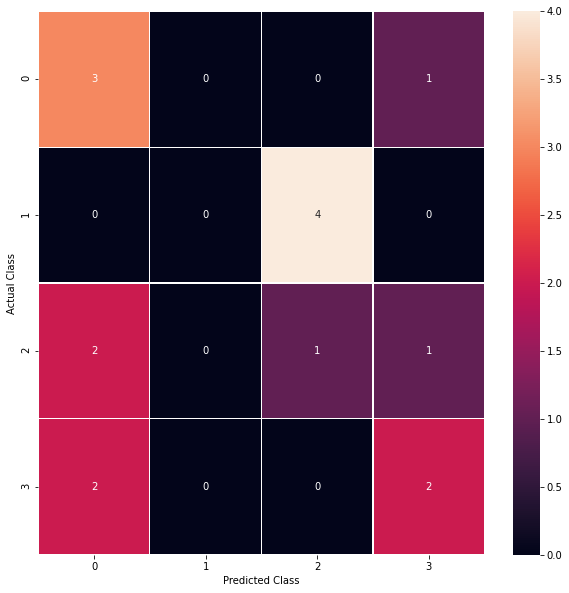

[4.0, 4.0, 3.0, 1.0, 3.0, 2.0, 2.0, 1.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 1.0, 2.0] [1.0, 4.0, 3.0, 4.0, 1.0, 3.0, 3.0, 1.0, 4.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 3.0]
              precision    recall  f1-score   support

         1.0       0.43      0.75      0.55         4
         2.0       0.00      0.00      0.00         4
         3.0       0.20      0.25      0.22         4
         4.0       0.50      0.50      0.50         4

    accuracy                           0.38        16
   macro avg       0.28      0.38      0.32        16
weighted avg       0.28      0.38      0.32        16



In [17]:
run(X23,y23,ocolumns)

In [17]:
def give_train_test(X1, y1, X2, y2, mode):
    if mode==0:X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
    if mode==1:X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
    if mode==2:
        X_train = X1
        y_train = y1
        X_test = X2
        y_test = y2
    if mode==3:
        X=np.array(list(X1)+list(X2))
        y=np.array(list(y1)+list(y2))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [18]:
def run_new(X_train,y_train,X_test,y_test):
    param_grid = {'C': [0.01,0.1, 1, 10, 100,1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10,100]}
    clf_grid = GridSearchCV(SVC(kernel = 'linear'), param_grid)
    clf_grid.fit(X_train, y_train)
#     print("Best Parameters:\n", clf_grid.best_params_
    
    svclassifier = SVC(kernel = 'linear',C = clf_grid.best_params_['C'], gamma = clf_grid.best_params_['gamma'])
    
    svclassifier.fit(X_train,y_train)
    
    y_pred = svclassifier.predict(X_test)
    #result = [y_pred[i] == y_test[i] for i in range(len(y_test))]
    f,ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, linewidths=.1, fmt= '.0f',ax=ax).set_ylim(4,0)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    print(list(y_test),list(y_pred))
    print(classification_report(y_test,y_pred))

(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 52.60it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 42.37it/s]


TSF finished


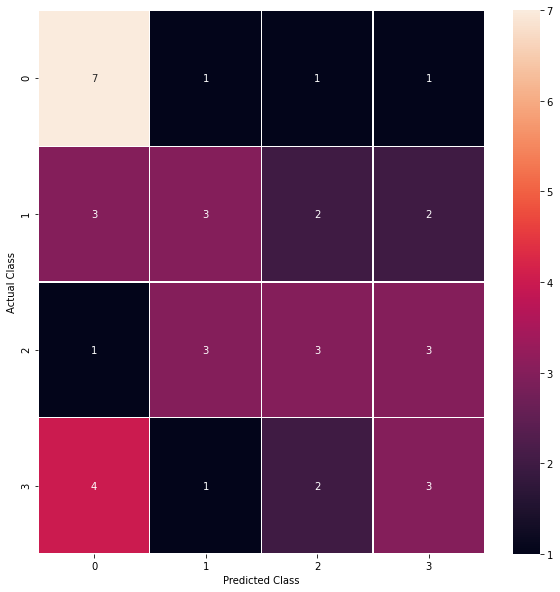

[1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0] [2.0, 1.0, 2.0, 1.0, 3.0, 4.0, 2.0, 1.0, 1.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 4.0, 3.0, 4.0, 1.0, 3.0, 2.0, 3.0, 2.0, 3.0, 1.0, 3.0]
              precision    recall  f1-score   support

         1.0       0.47      0.70      0.56        10
         2.0       0.38      0.30      0.33        10
         3.0       0.38      0.30      0.33        10
         4.0       0.33      0.30      0.32        10

    accuracy                           0.40        40
   macro avg       0.39      0.40      0.39        40
weighted avg       0.39      0.40      0.39        40



In [23]:
X1 = run_tsfresh(filtered_eegs1,labels1)
y1 = labels1
X2 = run_tsfresh(filtered_eegs2,labels2)
y2 = labels2

X_train, X_test, y_train, y_test = give_train_test(X1, y1, X2, y2, 2)
run_new(X_train,y_train,X_test,y_test)


(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 46.78it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 32.92it/s]


TSF finished


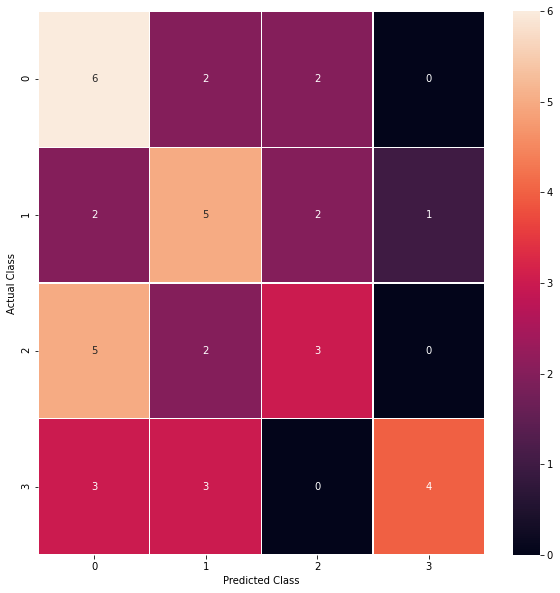

[1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0] [1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 4.0, 2.0, 2.0, 1.0, 2.0, 3.0, 3.0, 3.0, 2.0, 4.0, 3.0, 3.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 4.0, 4.0]
              precision    recall  f1-score   support

         1.0       0.38      0.60      0.46        10
         2.0       0.42      0.50      0.45        10
         3.0       0.43      0.30      0.35        10
         4.0       0.80      0.40      0.53        10

    accuracy                           0.45        40
   macro avg       0.51      0.45      0.45        40
weighted avg       0.51      0.45      0.45        40



In [18]:
X1 = run_tsfresh(filtered_eegs2,labels2)
y1 = labels2
X2 = run_tsfresh(filtered_eegs1,labels1)
y2 = labels1

X_train, X_test, y_train, y_test = give_train_test(X1, y1, X2, y2, 2)
run_new(X_train,y_train,X_test,y_test)



(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 43.18it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 48.11it/s]


TSF finished


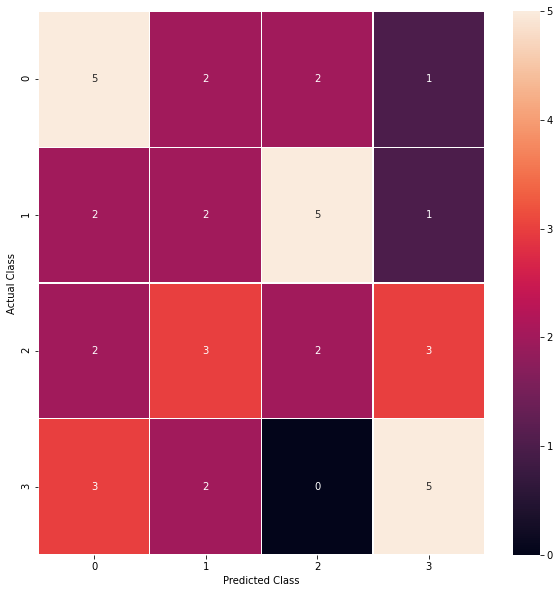

[1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0] [1.0, 1.0, 3.0, 3.0, 3.0, 2.0, 2.0, 4.0, 3.0, 1.0, 2.0, 2.0, 2.0, 3.0, 4.0, 1.0, 3.0, 1.0, 1.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 4.0, 1.0, 4.0]
              precision    recall  f1-score   support

         1.0       0.42      0.50      0.45        10
         2.0       0.22      0.20      0.21        10
         3.0       0.22      0.20      0.21        10
         4.0       0.50      0.50      0.50        10

    accuracy                           0.35        40
   macro avg       0.34      0.35      0.34        40
weighted avg       0.34      0.35      0.34        40



In [18]:
X1 = run_tsfresh(filtered_eegs21,labels21)
y1 = labels21
X2 = run_tsfresh(filtered_eegs22,labels22)
y2 = labels22

X_train, X_test, y_train, y_test = give_train_test(X1, y1, X2, y2, 2)
run_new(X_train,y_train,X_test,y_test)

(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 44.79it/s]


TSF finished
(768, 8) (768,)


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 28.71it/s]


TSF finished


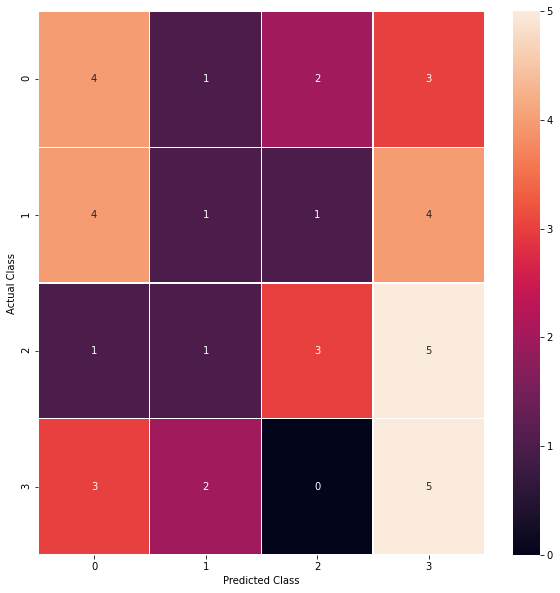

[1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0] [4.0, 1.0, 4.0, 1.0, 2.0, 3.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 2.0, 2.0, 4.0, 4.0, 1.0, 2.0, 4.0, 4.0, 4.0, 4.0, 1.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 1.0, 3.0, 2.0, 4.0, 3.0, 1.0, 4.0, 4.0, 1.0]
              precision    recall  f1-score   support

         1.0       0.33      0.40      0.36        10
         2.0       0.20      0.10      0.13        10
         3.0       0.50      0.30      0.37        10
         4.0       0.29      0.50      0.37        10

    accuracy                           0.33        40
   macro avg       0.33      0.33      0.31        40
weighted avg       0.33      0.33      0.31        40



In [19]:
X1 = run_tsfresh(filtered_eegs22,labels22)
y1 = labels22
X2 = run_tsfresh(filtered_eegs21,labels21)
y2 = labels21

X_train, X_test, y_train, y_test = give_train_test(X1, y1, X2, y2, 2)
run_new(X_train,y_train,X_test,y_test)

In [16]:
scaler = preprocessing.MinMaxScaler()   # since the data set is not gaussian
scaled_df = scaler.fit_transform(X11)
X11 = pd.DataFrame(scaled_df,columns = ocolumns)
X11.head()

,eeg1__spkt_welch_density__coeff_9,eeg1__spkt_welch_density__coeff_10,eeg1__spkt_welch_density__coeff_12,eeg1__spkt_welch_density__coeff_15,eeg2__spkt_welch_density__coeff_9,eeg2__spkt_welch_density__coeff_10,eeg2__spkt_welch_density__coeff_12,eeg2__spkt_welch_density__coeff_15,eeg3__spkt_welch_density__coeff_9,eeg3__spkt_welch_density__coeff_10,...,eeg6__spkt_welch_density__coeff_12,eeg6__spkt_welch_density__coeff_15,eeg7__spkt_welch_density__coeff_9,eeg7__spkt_welch_density__coeff_10,eeg7__spkt_welch_density__coeff_12,eeg7__spkt_welch_density__coeff_15,eeg8__spkt_welch_density__coeff_9,eeg8__spkt_welch_density__coeff_10,eeg8__spkt_welch_density__coeff_12,eeg8__spkt_welch_density__coeff_15
0,0.078458,0.000000,0.082858,0.592621,0.069686,0.033476,0.039440,0.485303,0.094847,0.178379,...,0.098729,0.515149,0.083310,0.071161,0.035698,0.403899,0.101287,0.007039,0.161776,0.219111
1,0.088861,0.021423,0.270706,0.704286,0.095792,0.043107,0.291638,0.596395,0.209185,0.119805,...,0.278375,0.666676,0.107496,0.075556,0.221805,0.500552,0.254235,0.263903,0.291994,0.114454
2,0.010456,0.006504,0.100459,0.079679,0.000000,0.000000,0.120063,0.098154,0.019407,0.000000,...,0.245135,0.045988,0.008363,0.010662,0.319200,0.077235,0.096402,0.110464,0.572603,0.107732
3,0.213417,0.015829,0.124429,0.163194,0.199963,0.054515,0.086010,0.161018,0.160590,0.127305,...,0.202748,0.122907,0.142535,0.177783,0.167773,0.164672,0.109984,0.177031,0.178389,0.167508
4,0.214356,0.648196,0.293946,0.295538,0.187450,0.594510,0.153591,0.276623,0.099387,0.460262,...,0.174134,0.231659,0.123869,0.999996,0.138244,0.336942,0.106253,0.309539,0.124740,0.130384


In [17]:
X11_train,X11_test,y11_train,y11_test = train_test_split(X11,y11,test_size = 0.20, stratify = y11)

svclassifier = SVC(kernel = 'linear',C = 1, gamma = 1)
# C = 1.0, gamma = 1.0 for linear kernel - selected using GridSearchCV - for dataset 40
# C = 1, gamma = 1 for rbf kernel - selected using GridSearchCV - for dataset 40
# C = 0.01, gamma = 10 for rbf kernel - selected using GridSearchCV - for dataset 80
# C = 10, gamma = 1 for linear kernel - selected using GridSearchCV - for dataset 80

svclassifier.fit(X11_train,y11_train)

SVC(C=1, gamma=1, kernel='linear')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

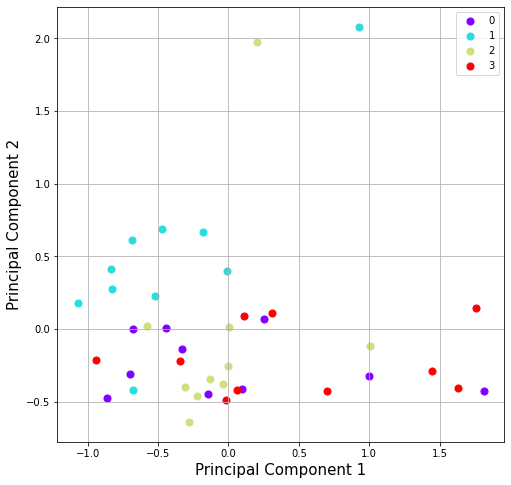

In [18]:
# dimensionality reduction to training set

pca = PCA(n_components = 2)
newFeatures = pca.fit_transform(X11)
newdf = pd.DataFrame(newFeatures,columns = ['Principal Component 1', 'Principal Component 2'])
#svclassifier.fit(newdf,y)
newdf['CLASS'] = [int(i)-1 for i in y11]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
clind = list(range(5))
colors = cm.rainbow(np.linspace(0, 1, 4))
for ind, color in zip(clind,colors):
    indicesToKeep = newdf['CLASS'] == ind
    ax.scatter(newdf.loc[indicesToKeep, 'Principal Component 1']
               , newdf.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(clind)
ax.grid()

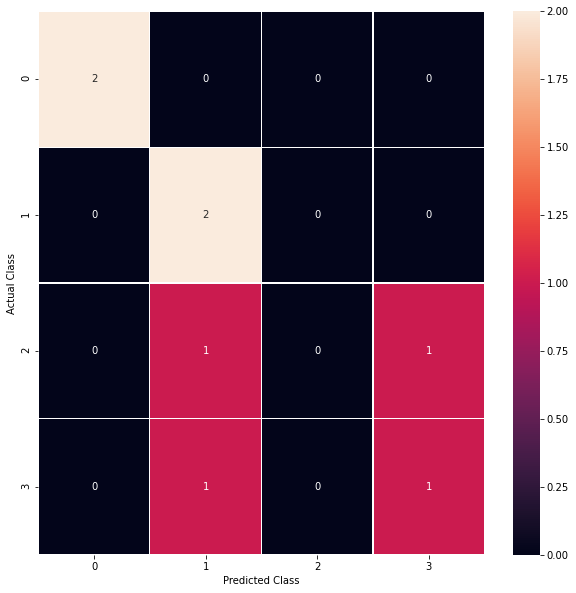

[3.0, 2.0, 4.0, 3.0, 2.0, 1.0, 1.0, 4.0] [2.0, 2.0, 2.0, 4.0, 2.0, 1.0, 1.0, 4.0]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         2
         2.0       0.50      1.00      0.67         2
         3.0       0.00      0.00      0.00         2
         4.0       0.50      0.50      0.50         2

    accuracy                           0.62         8
   macro avg       0.50      0.62      0.54         8
weighted avg       0.50      0.62      0.54         8



In [19]:
y_pred = svclassifier.predict(X11_test)
#result = [y_pred[i] == y_test[i] for i in range(len(y_test))]
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y11_test,y_pred), annot=True, linewidths=.1, fmt= '.0f',ax=ax).set_ylim(4,0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
print(list(y11_test),list(y_pred))
print(classification_report(y11_test,y_pred))

In [20]:
param_grid = {'C': [0.01,0.1, 1, 10, 100,1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10,100]}
clf_grid = GridSearchCV(SVC(kernel = 'linear'), param_grid)
clf_grid.fit(X11, y11)
print("Best Parameters:\n", clf_grid.best_params_)

Best Parameters:
 {'C': 1, 'gamma': 1}
